In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

In [2]:
base  = pd.read_excel('BaseHLCRM.xlsx')

#base= base.drop("Nombre",axis=1)
#base= base.drop("Apellido",axis=1)

In [3]:
base['Fecha Registro']=pd.to_datetime(base['Fecha Registro'],format="%Y-%m-%d")

In [4]:
FechaMax = base['Fecha Registro'].max()
print(FechaMax)

2020-02-23 00:00:00


In [91]:
 base['Fecha Registro'].min()

Timestamp('2019-08-04 00:00:00')

In [5]:
RFM = pd.DataFrame()

In [6]:
# Cargar catálogo de clientes

RFM['Mail']=base['Mail'].unique()

In [7]:
fechas = base.groupby(['Mail'])['Fecha Registro'].max().reset_index()

In [8]:
fechas.rename(columns = {'Fecha Registro': 'Fecha_Max'},inplace=True)

In [9]:
RFM2 = pd.merge(RFM,fechas, on='Mail',how='outer')

In [10]:
num_compras = base.groupby(['Mail'])['Fecha Registro'].nunique().reset_index()

In [11]:
num_compras.rename(columns = {'Fecha Registro': 'Frecuencia'},inplace=True)

In [12]:
num_compras.head()

Mail  Frecuencia
0                                   0          36
1         aaromendoza3490@hotmail.com           1
2           aarreguin075@yahoo.com.mx           1
3           abraham.vatr.93@gmail.com           1
4  al-olivaresdelcastillo@hotmail.com           1

In [13]:
RFM3 = pd.merge(RFM2,num_compras, on='Mail')

In [14]:
RFM3.head()

Mail  Fecha_Max  Frecuencia
0  alejandro_velzam@hotmail.com 2020-01-12           1
1      alexolgin.1885@gmail.com 2020-01-06           1
2     zaragozarguez@hotmail.com 2020-01-05           1
3                             0 2020-02-23          36
4           mar-nto@hotmail.com 2020-02-21           1

In [15]:
monto = base.groupby(['Mail'])['Importe'].sum().reset_index()
RFM4 = pd.merge(RFM3,monto, on='Mail')
RFM4['Dias'] = FechaMax - RFM4['Fecha_Max']
RFM4['Dias']=RFM4['Dias'].astype('timedelta64[D]')

In [16]:
RFM4.head()

Mail  Fecha_Max  Frecuencia    Importe  Dias
0  alejandro_velzam@hotmail.com 2020-01-12           1   10750.00  42.0
1      alexolgin.1885@gmail.com 2020-01-06           1   23597.41  48.0
2     zaragozarguez@hotmail.com 2020-01-05           1   16830.17  49.0
3                             0 2020-02-23          36  442778.99   0.0
4           mar-nto@hotmail.com 2020-02-21           1    4025.86   2.0

In [17]:
RFM4.quantile(np.linspace(0,1,6))

Frecuencia     Importe   Dias
0.0         1.0     171.550    0.0
0.2         1.0    2122.932   98.0
0.4         1.0    4400.004  105.8
0.6         1.0    6292.070  120.0
0.8         1.0   10813.624  135.6
1.0        36.0  442778.990  196.0

### Limpieza

Observamos que el usuario con Mail '0' tiene una frecuencia de 36 compras, lo cual es un error de asignación de tickets con un importe de $442,778

Por lo cual eliminaremos ese registro y así los intervalos o quintiles estén mejor balanceados.

In [21]:
RFM4[RFM4['Frecuencia']==36]

Mail  Fecha_Max  Frecuencia    Importe  Dias
3    0 2020-02-23          36  442778.99   0.0

In [22]:
RFM4 = RFM4[RFM4['Frecuencia']!=36]

In [25]:
RFM4.quantile(np.linspace(0,1,6))

Frecuencia    Importe   Dias
0.0         1.0    171.550    2.0
0.2         1.0   2115.346   98.2
0.4         1.0   4346.552  106.0
0.6         1.0   6286.034  120.0
0.8         1.0  10693.794  135.8
1.0         2.0  39099.140  196.0

In [26]:
lista_dias = RFM4.quantile(np.linspace(0,1,6))['Dias'].to_list()
inter_dias= []
for x in range(0,5):
    inter_dias.append(list( ( lista_dias[x],lista_dias[x+1]) ) )
    
    
inter_dias.reverse()

inter_dias

[[135.8, 196.0], [120.0, 135.8], [106.0, 120.0], [98.2, 106.0], [2.0, 98.2]]

In [27]:
lista_imp = RFM4.quantile(np.linspace(0,1,6))['Importe'].to_list()
inter_imp= []
for x in range(0,5):
    inter_imp.append(list( ( lista_imp[x],lista_imp[x+1]) ) )
    
inter_imp

[[171.55, 2115.3460000000005],
 [2115.3460000000005, 4346.5520000000015],
 [4346.5520000000015, 6286.034],
 [6286.034, 10693.794000000004],
 [10693.794000000004, 39099.14]]

In [30]:
RFM4.quantile(np.linspace(0,1,5))['Frecuencia'].to_list()

[1.0, 1.0, 1.0, 1.0, 2.0]

### Frecuencia

En este caso tenemos un conjunto de datos muy poco variado en cuanto a la frecuencia.
Analizaremos el data set solo con 2 varialbes que son los días y el importe.


In [53]:
RFM4

Mail  Fecha_Max  Frecuencia   Importe   Dias
0       alejandro_velzam@hotmail.com 2020-01-12           1  10750.00   42.0
1           alexolgin.1885@gmail.com 2020-01-06           1  23597.41   48.0
2          zaragozarguez@hotmail.com 2020-01-05           1  16830.17   49.0
4                mar-nto@hotmail.com 2020-02-21           1   4025.86    2.0
5             heribert34@hotmail.com 2019-11-05           1   1715.52  110.0
6             martinezpasi@gmail.com 2019-11-02           1   3431.03  113.0
7              alexseeaman@gmail.com 2019-12-01           2   5839.65   84.0
8          cuatroideas83@hotmail.com 2019-10-27           1   1450.86  119.0
9                 mgalecar@gmail.com 2019-10-21           1   1715.51  125.0
10   archundiavidalbrandon@gmail.com 2019-10-20           1   4887.93  126.0
11               jfgodinez@gmail.com 2019-10-20           1   2918.96  126.0
12          juliocasares@hotmail.com 2019-10-19           1   1715.52  127.0
13             brachew2@yahoo.com.mx 2019-10-15           1  18261.21  131.0
14                olet26@hotmail.com 2020-02-14           1    861.21    9.0
15      villegaschavezcp@hotmail.com 2020-01-29           1   3142.24   25.0
16         franz.peralta@hotmail.com 2019-11-17           1   5131.04   98.0
17             cbalestra@twsolar.com 2020-01-10           1   8075.86   44.0
18        lisbetgrijalva@hotmail.com 2019-12-29           1  19818.97   56.0
19          moroni_wide@yahoo.com.mx 2020-01-12           1   1892.24   42.0
20           hetfield94_@hotmail.com 2019-12-07           1   6890.52   78.0
21               gatisiris1313@h.com 2019-11-26           1   6188.79   89.0
22              morenobaez@gmail.com 2019-10-18           1   2150.86  128.0
23                auvisa@hotmail.com 2019-09-26           1   2574.15  150.0
24              edgar_rt@outlook.com 2019-12-01           1   2325.00   84.0
25              laloalri@hotmail.com 2019-10-13           1   3421.55  133.0
26          mau.rdg-leal@hotmail.com 2019-11-02           1   4732.76  113.0
27    moises.deoca.lopez@banorte.com 2019-11-17           1    857.76   98.0
28         victor_tafoya@hotmail.com 2019-11-13           1   5882.76  102.0
29       pilarprincipes@yahoo.com.mx 2019-10-26           1   2537.06  120.0
30                  alan@alfo.com.mx 2019-11-17           1  17474.14   98.0
..                               ...        ...         ...       ...    ...
163   licalfredomtzlopez@hotmail.com 2019-10-06           1   5002.58  140.0
164             vicos_22@hotmail.com 2019-11-01           1   8316.81  114.0
165          jg@gnmcontadores.com.mx 2019-11-02           1   9589.66  113.0
166     j_manuel_flores@yahoo.com.mx 2019-10-20           1   7407.76  126.0
167      carloslopeztemp06@gmail.com 2019-09-01           1   9034.48  175.0
168      carloscorsoosorio@gmail.com 2019-10-12           1   2769.83  134.0
169       drrosalesplastic@gmail.com 2019-11-03           1   3439.66  112.0
170      carlos_pifi_esm@hotmail.com 2019-11-02           1  12256.90  113.0
171         fernando@mag_medical.com 2019-09-06           1  16525.01  170.0
172          galanjaz@prodigy.net.mx 2019-10-10           1  18163.79  136.0
173     sandrae_escobedo@hotmail.com 2019-10-26           1   9258.59  120.0
174        icarboney@adcomviajes.com 2019-09-06           1   2516.38  170.0
175          raul_olivera@icloud.com 2019-08-18           1  10059.48  189.0
176      rgonzalez@corporativorg.com 2019-11-06           1  35475.43  109.0
177            mike.dorado@gmail.com 2019-10-19           1   2769.83  127.0
178        maciaspedroluis@gmail.com 2019-09-21           1   1715.52  155.0
179  daniel_rodriguez940@hotmail.com 2019-09-08           1  21107.75  168.0
180             fransalp@outlook.com 2019-09-03           1  12233.19  173.0
181              slala1506@gmail.com 2019-10-07           1  14759.52  139.0
182             gregmtz.go@gmail.com 2019-11-13           1   1723.28  102.0
183            rogrerpez@hot

In [54]:
# RFM Días sin compra 
for x,y in RFM4.iterrows():
    for z in range(len(inter_dias)):
        if (y['Dias']>=inter_dias[z][0] and y['Dias']<= inter_dias[z][1]):
            print(y['Dias'],inter_dias[z][0],inter_dias[z][1],z+1)
            RFM4.loc[x,'R_class']=(z+1)

42.0 2.0 98.2 5
48.0 2.0 98.2 5
49.0 2.0 98.2 5
2.0 2.0 98.2 5
110.0 106.0 120.0 3
113.0 106.0 120.0 3
84.0 2.0 98.2 5
119.0 106.0 120.0 3
125.0 120.0 135.8 2
126.0 120.0 135.8 2
126.0 120.0 135.8 2
127.0 120.0 135.8 2
131.0 120.0 135.8 2
9.0 2.0 98.2 5
25.0 2.0 98.2 5
98.0 2.0 98.2 5
44.0 2.0 98.2 5
56.0 2.0 98.2 5
42.0 2.0 98.2 5
78.0 2.0 98.2 5
89.0 2.0 98.2 5
128.0 120.0 135.8 2
150.0 135.8 196.0 1
84.0 2.0 98.2 5
133.0 120.0 135.8 2
113.0 106.0 120.0 3
98.0 2.0 98.2 5
102.0 98.2 106.0 4
120.0 120.0 135.8 2
120.0 106.0 120.0 3
98.0 2.0 98.2 5
125.0 120.0 135.8 2
99.0 98.2 106.0 4
91.0 2.0 98.2 5
133.0 120.0 135.8 2
105.0 98.2 106.0 4
105.0 98.2 106.0 4
190.0 135.8 196.0 1
196.0 135.8 196.0 1
99.0 98.2 106.0 4
121.0 120.0 135.8 2
167.0 135.8 196.0 1
103.0 98.2 106.0 4
100.0 98.2 106.0 4
89.0 2.0 98.2 5
182.0 135.8 196.0 1
93.0 2.0 98.2 5
100.0 98.2 106.0 4
85.0 2.0 98.2 5
141.0 135.8 196.0 1
99.0 98.2 106.0 4
196.0 135.8 196.0 1
105.0 98.2 106.0 4
169.0 135.8 196.0 1
137.0 135.8 196

In [56]:
# RFM Monto sin compra
for x,y in RFM4.iterrows():
    for z in range(len(inter_imp)):
        if (y['Importe']>=inter_imp[z][0] and y['Importe']<= inter_imp[z][1]):
            print(y['Importe'],inter_imp[z][0],inter_imp[z][1],z+1)
            RFM4.loc[x,'M_class']=(z+1)

10750.0 10693.794000000004 39099.14 5
23597.41 10693.794000000004 39099.14 5
16830.17 10693.794000000004 39099.14 5
4025.8600000000006 2115.3460000000005 4346.5520000000015 2
1715.52 171.55 2115.3460000000005 1
3431.0299999999997 2115.3460000000005 4346.5520000000015 2
5839.65 4346.5520000000015 6286.034 3
1450.8600000000001 171.55 2115.3460000000005 1
1715.51 171.55 2115.3460000000005 1
4887.93 4346.5520000000015 6286.034 3
2918.96 2115.3460000000005 4346.5520000000015 2
1715.52 171.55 2115.3460000000005 1
18261.21 10693.794000000004 39099.14 5
861.21 171.55 2115.3460000000005 1
3142.24 2115.3460000000005 4346.5520000000015 2
5131.04 4346.5520000000015 6286.034 3
8075.86 6286.034 10693.794000000004 4
19818.97 10693.794000000004 39099.14 5
1892.24 171.55 2115.3460000000005 1
6890.52 6286.034 10693.794000000004 4
6188.79 4346.5520000000015 6286.034 3
2150.86 2115.3460000000005 4346.5520000000015 2
2574.15 2115.3460000000005 4346.5520000000015 2
2325.0 2115.3460000000005 4346.55200000000

In [57]:
RFM4

Mail  Fecha_Max  Frecuencia   Importe   Dias  \
0       alejandro_velzam@hotmail.com 2020-01-12           1  10750.00   42.0   
1           alexolgin.1885@gmail.com 2020-01-06           1  23597.41   48.0   
2          zaragozarguez@hotmail.com 2020-01-05           1  16830.17   49.0   
4                mar-nto@hotmail.com 2020-02-21           1   4025.86    2.0   
5             heribert34@hotmail.com 2019-11-05           1   1715.52  110.0   
6             martinezpasi@gmail.com 2019-11-02           1   3431.03  113.0   
7              alexseeaman@gmail.com 2019-12-01           2   5839.65   84.0   
8          cuatroideas83@hotmail.com 2019-10-27           1   1450.86  119.0   
9                 mgalecar@gmail.com 2019-10-21           1   1715.51  125.0   
10   archundiavidalbrandon@gmail.com 2019-10-20           1   4887.93  126.0   
11               jfgodinez@gmail.com 2019-10-20           1   2918.96  126.0   
12          juliocasares@hotmail.com 2019-10-19           1   1715.52  127.0   
13             brachew2@yahoo.com.mx 2019-10-15           1  18261.21  131.0   
14                olet26@hotmail.com 2020-02-14           1    861.21    9.0   
15      villegaschavezcp@hotmail.com 2020-01-29           1   3142.24   25.0   
16         franz.peralta@hotmail.com 2019-11-17           1   5131.04   98.0   
17             cbalestra@twsolar.com 2020-01-10           1   8075.86   44.0   
18        lisbetgrijalva@hotmail.com 2019-12-29           1  19818.97   56.0   
19          moroni_wide@yahoo.com.mx 2020-01-12           1   1892.24   42.0   
20           hetfield94_@hotmail.com 2019-12-07           1   6890.52   78.0   
21               gatisiris1313@h.com 2019-11-26           1   6188.79   89.0   
22              morenobaez@gmail.com 2019-10-18           1   2150.86  128.0   
23                auvisa@hotmail.com 2019-09-26           1   2574.15  150.0   
24              edgar_rt@outlook.com 2019-12-01           1   2325.00   84.0   
25              laloalri@hotmail.com 2019-10-13           1   3421.55  133.0   
26          mau.rdg-leal@hotmail.com 2019-11-02           1   4732.76  113.0   
27    moises.deoca.lopez@banorte.com 2019-11-17           1    857.76   98.0   
28         victor_tafoya@hotmail.com 2019-11-13           1   5882.76  102.0   
29       pilarprincipes@yahoo.com.mx 2019-10-26           1   2537.06  120.0   
30                  alan@alfo.com.mx 2019-11-17           1  17474.14   98.0   
..                               ...        ...         ...       ...    ...   
163   licalfredomtzlopez@hotmail.com 2019-10-06           1   5002.58  140.0   
164             vicos_22@hotmail.com 2019-11-01           1   8316.81  114.0   
165          jg@gnmcontadores.com.mx 2019-11-02           1   9589.66  113.0   
166     j_manuel_flores@yahoo.com.mx 2019-10-20           1   7407.76  126.0   
167      carloslopeztemp06@gmail.com 2019-09-01           1   9034.48  175.0   
168      carloscorsoosorio@gmail.com 2019-10-12           1   2769.83  134.0   
169       drrosalesplastic@gmail.com 2019-11-03           1   3439.66  112.0   
170      carlos_pifi_esm@hotmail.com 2019-11-02           1  12256.90  113.0   
171         fernando@mag_medical.com 2019-09-06           1  16525.01  170.0   
172          galanjaz@prodigy.net.mx 2019-10-10           1  18163.79  136.0   
173     sandrae_escobedo@hotmail.com 2019-10-26           1   9258.59  120.0   
174        icarboney@adcomviajes.com 2019-09-06           1   2516.38  170.0   
175          raul_olivera@icloud.com 2019-08-18           1  10059.48  189.0   
176      rgonzalez@corporativorg.com 2019-11-06           1  35475.43  109.0   
177            mike.dorado@gmail.com 2019-10-19           1   2769.83  127.0   
178        maciaspedroluis@gmail.com 2019-09-21           1   1715.52  155.0   
179  daniel_rodriguez940@hotmail.com 2019-09-08           1  21107.75  168.0   
180             fransalp@outlook.com 2019-09-03           1  12233.19  173.0   
181              slala1506@gmail

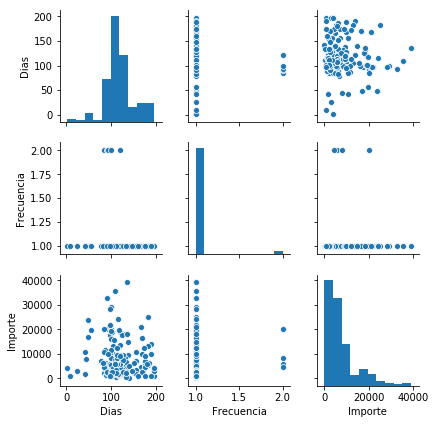

In [58]:
sb.pairplot(RFM4,height=2,vars=['Dias','Frecuencia','Importe'],kind ='scatter')
plt.show()

## Creación de clusters

In [78]:
X = np.array(RFM4[['R_class','M_class']])
X.shape

(192, 2)

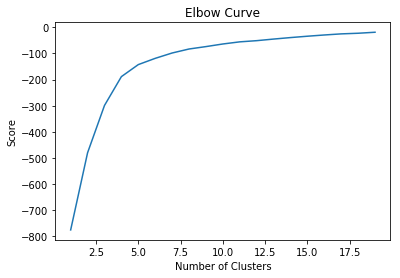

In [79]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [85]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[3.79365079 1.9047619 ]
 [1.93023256 4.41860465]
 [4.63414634 4.34146341]
 [1.48888889 1.95555556]]


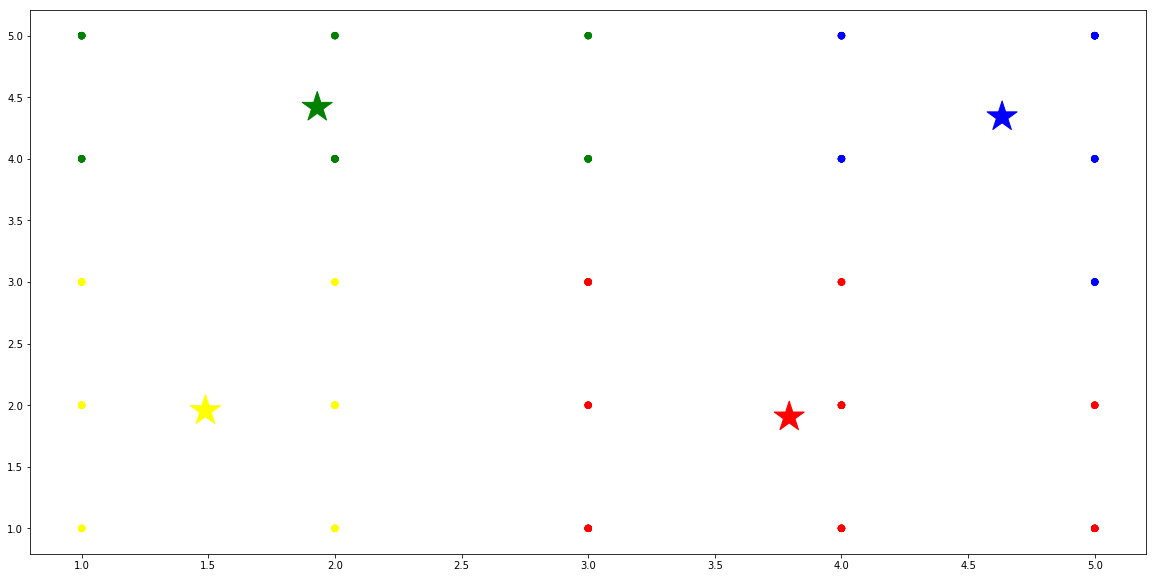

In [86]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
#colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure(figsize=(20,10))
#ax = Axes3D(fig)
plt.scatter(X[:, 0], X[:, 1],  c=asignar,s=40)
plt.scatter(C[:, 0], C[:, 1],  marker='*', c=colores, s=1000)
plt.show()

In [87]:
copia =  pd.DataFrame()
copia['Mail']=RFM4['Mail'].values
#copy['categoria']=dataframe['categoria'].values
copia['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copia.groupby('label').size()
cantidadGrupo

color  cantidad
0     red        63
1   green        43
2    blue        41
3  yellow        45

In [88]:
RFM6=pd.merge(RFM4,copia,on='Mail')

In [89]:
RFM6

Mail  Fecha_Max  Frecuencia   Importe   Dias  \
0       alejandro_velzam@hotmail.com 2020-01-12           1  10750.00   42.0   
1           alexolgin.1885@gmail.com 2020-01-06           1  23597.41   48.0   
2          zaragozarguez@hotmail.com 2020-01-05           1  16830.17   49.0   
3                mar-nto@hotmail.com 2020-02-21           1   4025.86    2.0   
4             heribert34@hotmail.com 2019-11-05           1   1715.52  110.0   
5             martinezpasi@gmail.com 2019-11-02           1   3431.03  113.0   
6              alexseeaman@gmail.com 2019-12-01           2   5839.65   84.0   
7          cuatroideas83@hotmail.com 2019-10-27           1   1450.86  119.0   
8                 mgalecar@gmail.com 2019-10-21           1   1715.51  125.0   
9    archundiavidalbrandon@gmail.com 2019-10-20           1   4887.93  126.0   
10               jfgodinez@gmail.com 2019-10-20           1   2918.96  126.0   
11          juliocasares@hotmail.com 2019-10-19           1   1715.52  127.0   
12             brachew2@yahoo.com.mx 2019-10-15           1  18261.21  131.0   
13                olet26@hotmail.com 2020-02-14           1    861.21    9.0   
14      villegaschavezcp@hotmail.com 2020-01-29           1   3142.24   25.0   
15         franz.peralta@hotmail.com 2019-11-17           1   5131.04   98.0   
16             cbalestra@twsolar.com 2020-01-10           1   8075.86   44.0   
17        lisbetgrijalva@hotmail.com 2019-12-29           1  19818.97   56.0   
18          moroni_wide@yahoo.com.mx 2020-01-12           1   1892.24   42.0   
19           hetfield94_@hotmail.com 2019-12-07           1   6890.52   78.0   
20               gatisiris1313@h.com 2019-11-26           1   6188.79   89.0   
21              morenobaez@gmail.com 2019-10-18           1   2150.86  128.0   
22                auvisa@hotmail.com 2019-09-26           1   2574.15  150.0   
23              edgar_rt@outlook.com 2019-12-01           1   2325.00   84.0   
24              laloalri@hotmail.com 2019-10-13           1   3421.55  133.0   
25          mau.rdg-leal@hotmail.com 2019-11-02           1   4732.76  113.0   
26    moises.deoca.lopez@banorte.com 2019-11-17           1    857.76   98.0   
27         victor_tafoya@hotmail.com 2019-11-13           1   5882.76  102.0   
28       pilarprincipes@yahoo.com.mx 2019-10-26           1   2537.06  120.0   
29                  alan@alfo.com.mx 2019-11-17           1  17474.14   98.0   
..                               ...        ...         ...       ...    ...   
162   licalfredomtzlopez@hotmail.com 2019-10-06           1   5002.58  140.0   
163             vicos_22@hotmail.com 2019-11-01           1   8316.81  114.0   
164          jg@gnmcontadores.com.mx 2019-11-02           1   9589.66  113.0   
165     j_manuel_flores@yahoo.com.mx 2019-10-20           1   7407.76  126.0   
166      carloslopeztemp06@gmail.com 2019-09-01           1   9034.48  175.0   
167      carloscorsoosorio@gmail.com 2019-10-12           1   2769.83  134.0   
168       drrosalesplastic@gmail.com 2019-11-03           1   3439.66  112.0   
169      carlos_pifi_esm@hotmail.com 2019-11-02           1  12256.90  113.0   
170         fernando@mag_medical.com 2019-09-06           1  16525.01  170.0   
171          galanjaz@prodigy.net.mx 2019-10-10           1  18163.79  136.0   
172     sandrae_escobedo@hotmail.com 2019-10-26           1   9258.59  120.0   
173        icarboney@adcomviajes.com 2019-09-06           1   2516.38  170.0   
174          raul_olivera@icloud.com 2019-08-18           1  10059.48  189.0   
175      rgonzalez@corporativorg.com 2019-11-06           1  35475.43  109.0   
176            mike.dorado@gmail.com 2019-10-19           1   2769.83  127.0   
177        maciaspedroluis@gmail.com 2019-09-21           1   1715.52  155.0   
178  daniel_rodriguez940@hotmail.com 2019-09-08           1  21107.75  168.0   
179             fransalp@outlook.com 2019-09-03           1  12233.19  173.0   
180              slala1506@gmail

In [90]:
RFM6.to_excel('HL-ClassClientesClustersRFM.xlsx',index=False)